In [ ]:
# !pip install easyocr -U
# !pip install python-Levenshtein -U
# !pip install pytesseract -U
# !apt install tesseract-ocr
# !apt install libtesseract-dev
# !python3 -m pip install paddlepaddle-gpu -U
# !pip install paddleocr -U

In [9]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import easyocr
import numpy as np
import pandas as pd
import Levenshtein
import matplotlib.pyplot as plt
import pytesseract
from paddleocr import PaddleOCR, draw_ocr

# Import Images

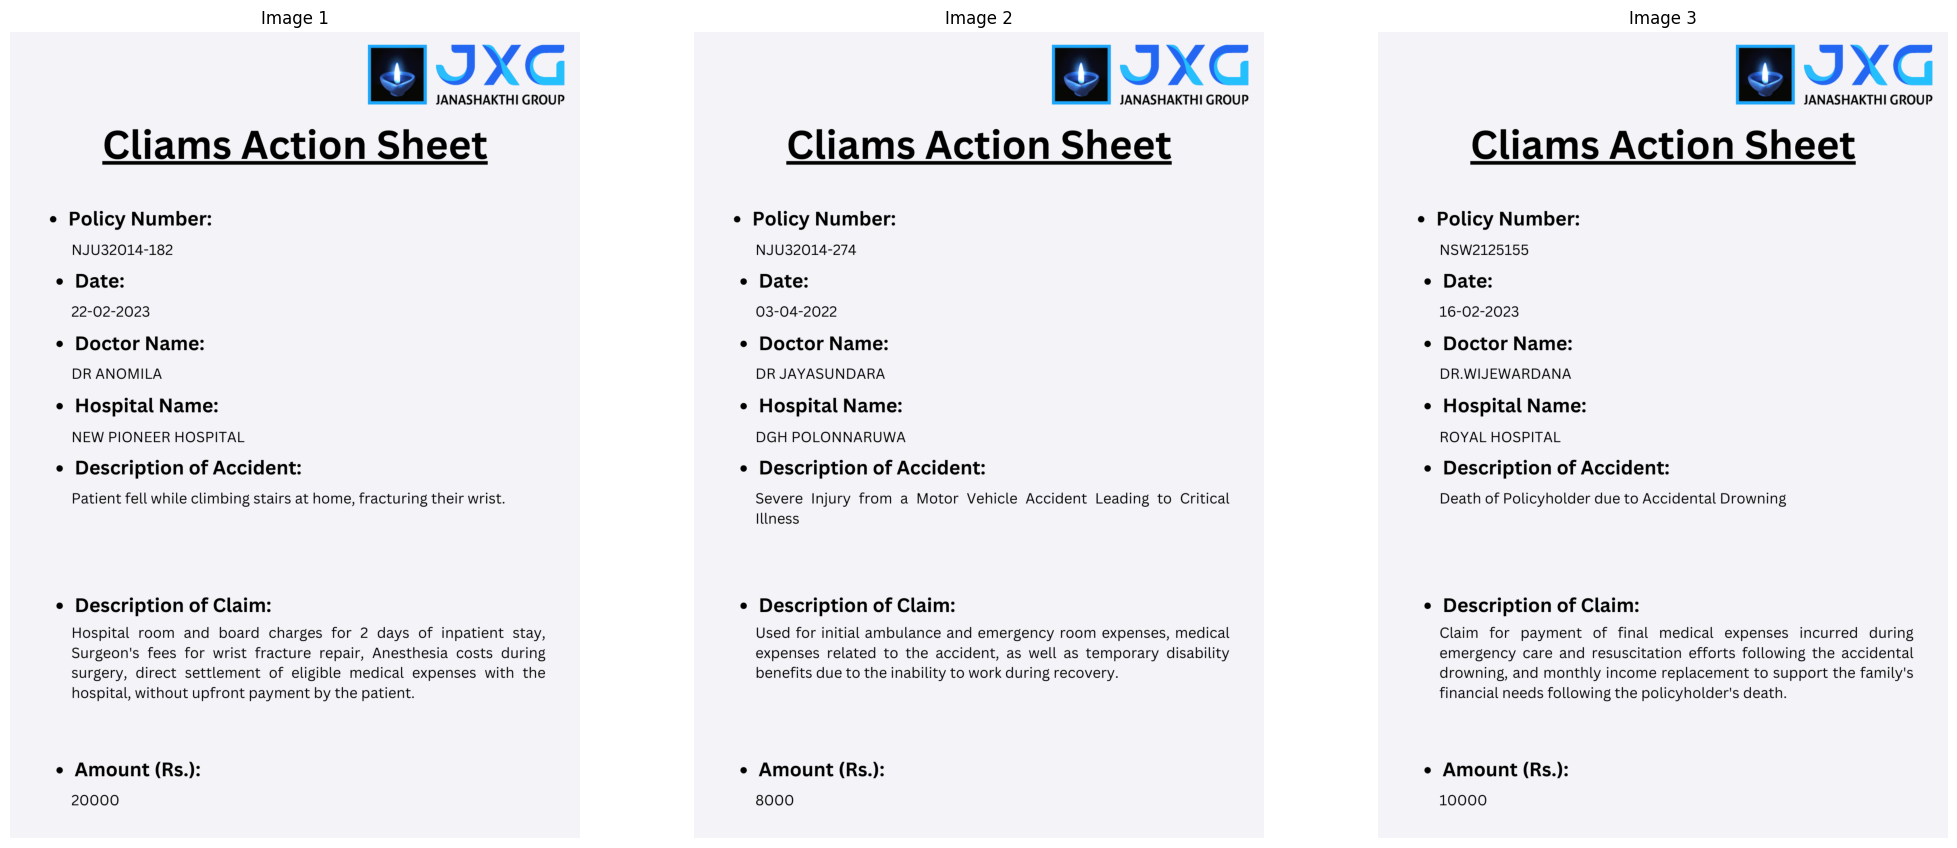

In [10]:
fig = plt.figure(figsize=(25,40))

for i in range(1,4):
  img = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4996/Claim_forms/{i}.png')
  fig.add_subplot(1, 3, i)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Image {i}')

# Prepair Image Set

In [11]:
img = {}

for i in range(1,16):
  img[f'BGR image {i}'] = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4996/Claim_forms/{i}.png')
  img[f'RGB image {i}'] = cv.cvtColor(img[f'BGR image {i}'], cv.COLOR_BGR2RGB)
  img[f'GrayScale image {i}'] = cv.cvtColor(img[f'BGR image {i}'], cv.COLOR_BGR2GRAY)
  _ , img[f'OTSU_85 image {i}'] = cv.threshold(img[f'GrayScale image {i}'], 85, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

raw_image_type = ['BGR', 'RGB', 'GrayScale', 'OTSU_85']
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

for image_type in raw_image_type:
  for i in range(1,16):
    img[f"{image_type} Sharpen image {i}"] = cv.filter2D(img[f'{image_type} image {i}'], ddepth=-1, kernel=kernel)

# Plot the Image Set

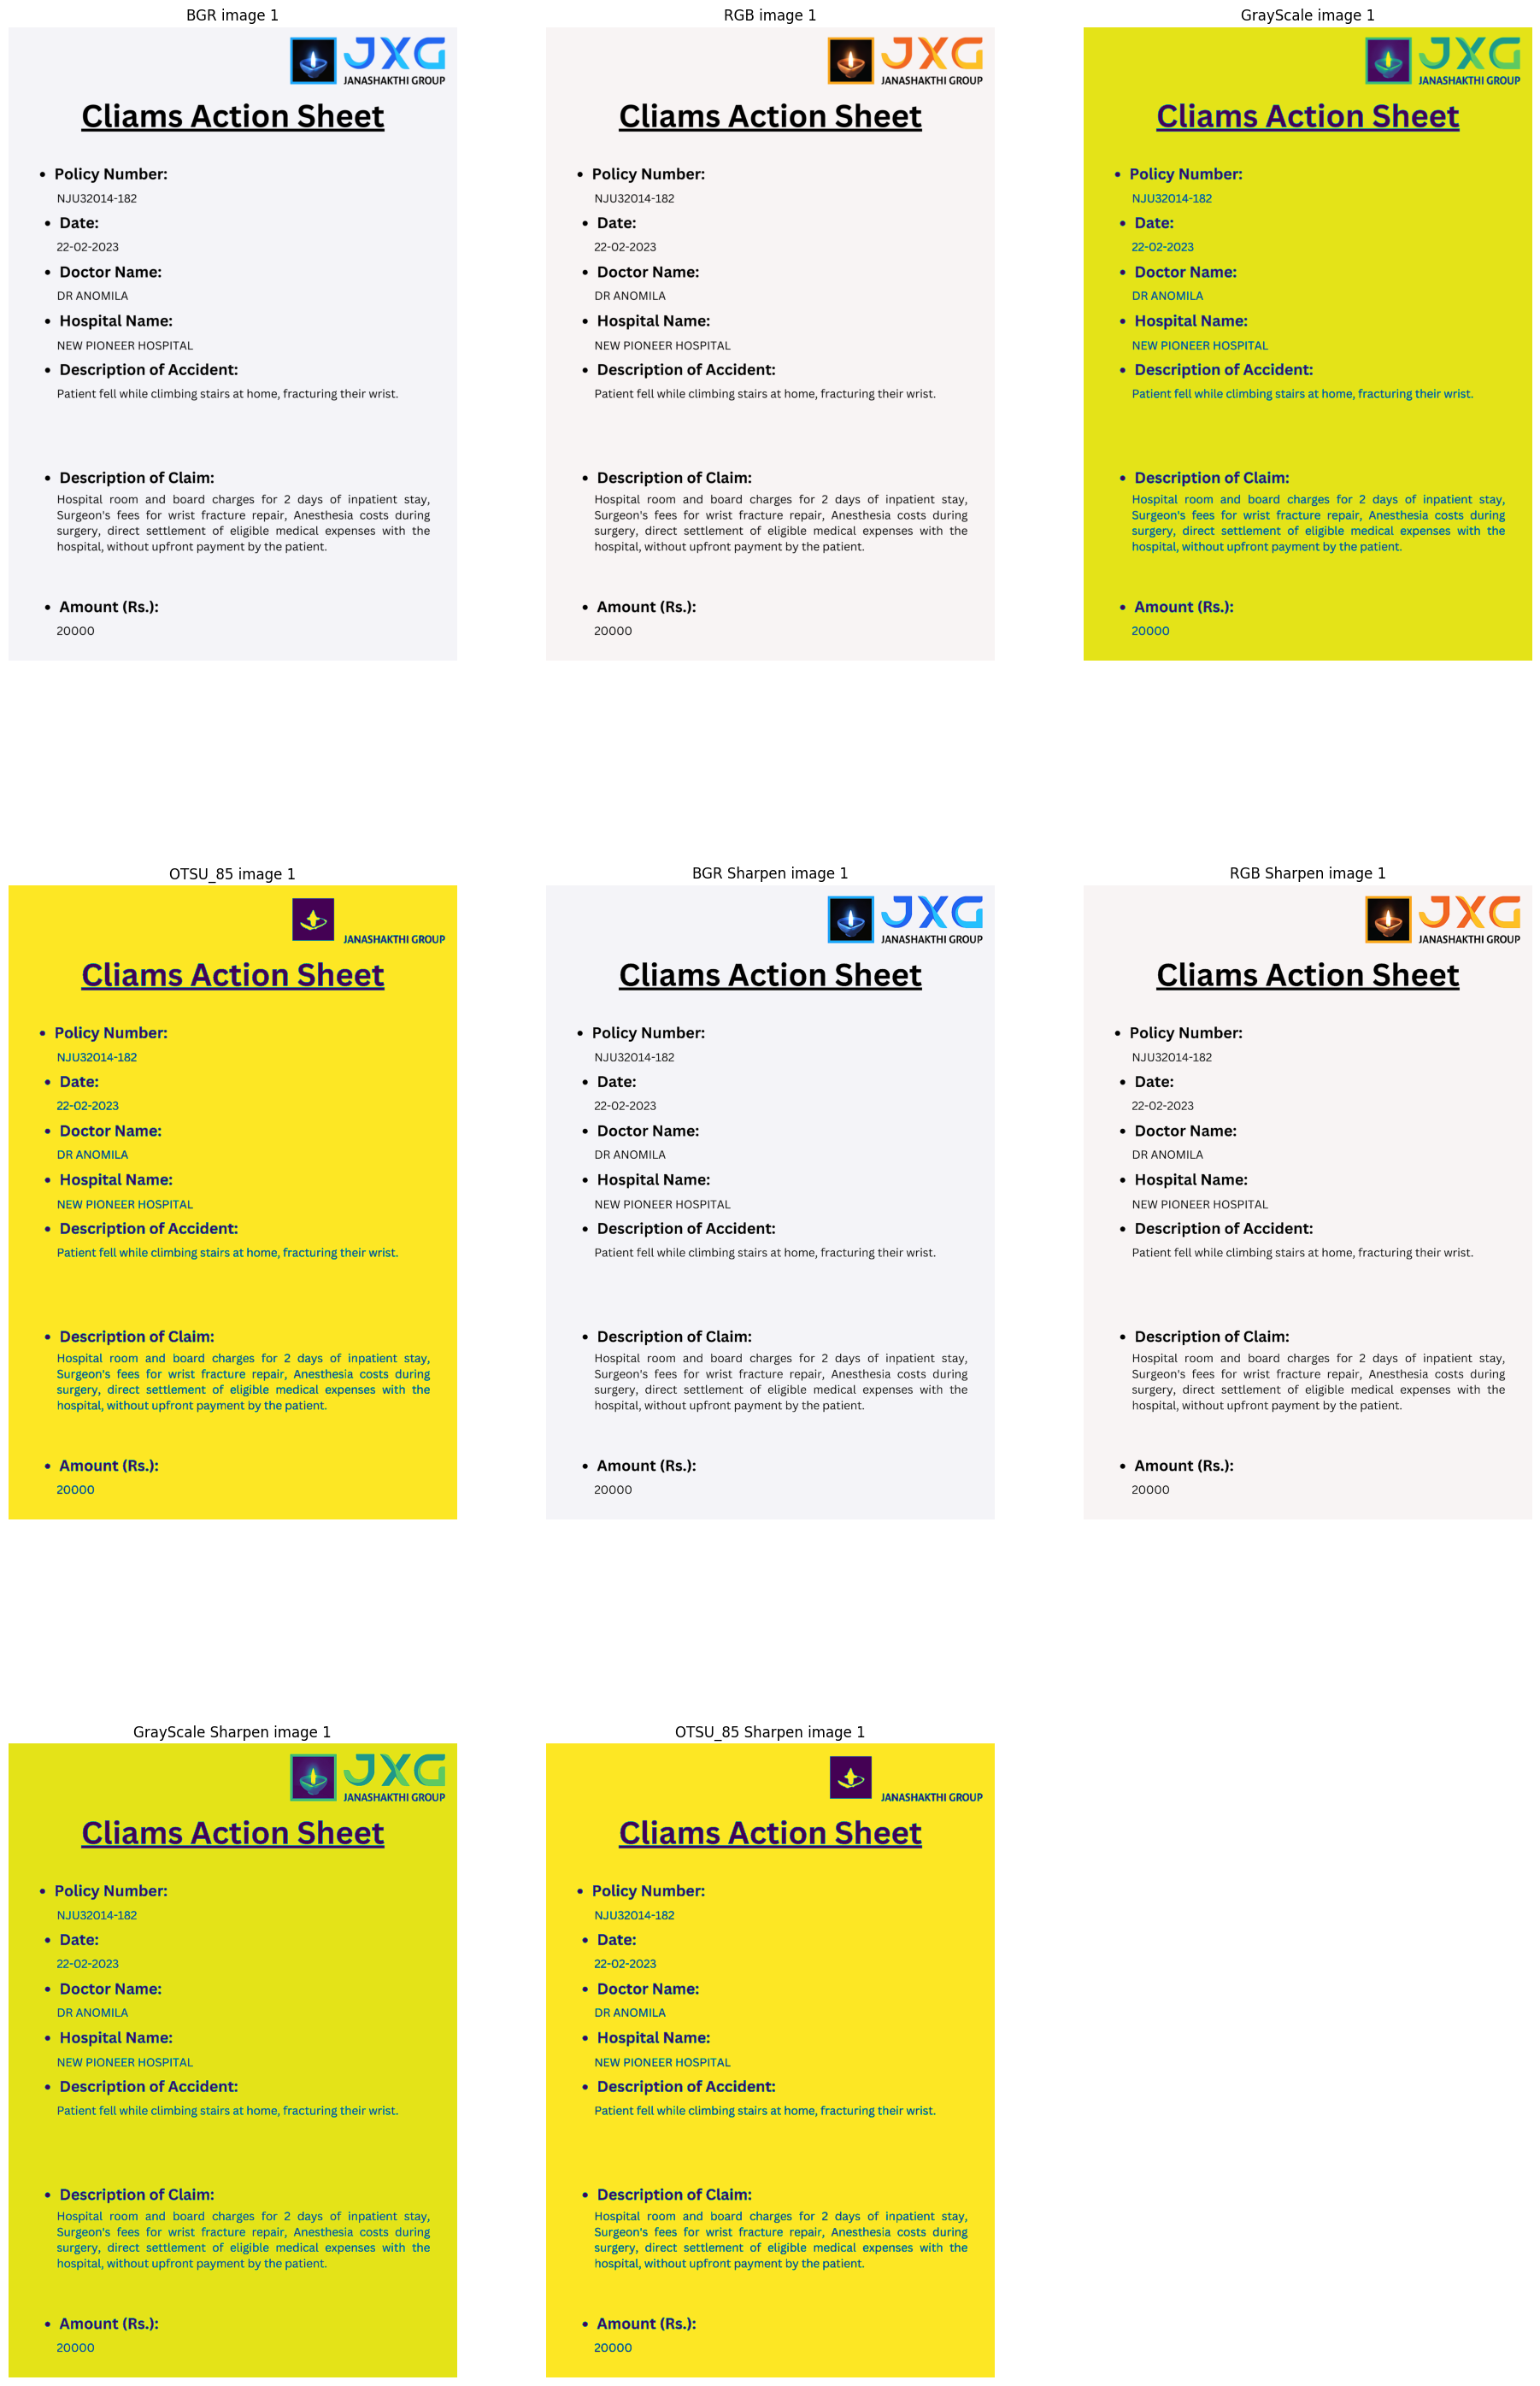

In [12]:
image_type = ['BGR', 'RGB', 'GrayScale', 'OTSU_85', 'BGR Sharpen', 'RGB Sharpen', 'GrayScale Sharpen', 'OTSU_85 Sharpen']

position = 1
fig = plt.figure(figsize=(23, 50))

for img_type in image_type:
  fig.add_subplot(4, 3, position)

  plt.imshow(img[f'{img_type} image 1'])
  plt.axis('off')
  plt.title(f"{img_type} image 1")

  position += 1

# **Finding the best image input type among BGR, RGB, GrayScale, BGR Sharpen, RGB Sharpen, and GrayScale Sharpen using EasyOCR, PaddlePaddleOCR, and PyTesseract with Levenshtein's CER, WER values**

### EasyOCR Model

In [13]:
def easyOCR(image):
  reader = easyocr.Reader(['en'])
  result = reader.readtext(image)

  text = ''
  for i in range(0,len(result)):
    text += result[i][1] + " "

  text = text.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ')

  return text.strip()

### Predicting Text using EasyOCR for each image input type

In [14]:
predicted_text = {}

for i in range(1,16):
  for input_img in image_type:
    predicted_text[f'{input_img} image {i} EasyOCR text'] = easyOCR(img[f'{input_img} image {i}'])
    if i==1:
      print("")
      print(f"{input_img} image {i} EasyOCR text :-")
      print(predicted_text[f'{input_img} image {i} EasyOCR text'])
      print("")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteBGR image 1 EasyOCR text :-
JXG JANASHAKTHI GROUP Cliams Action Sheet Policy Number: NJU32014-182 Date: 22-02-2023 Doctor Name: DR ANOMILA Hospital Name: NEW PIONEER HOSPITAL Description of Accident: Patient fell while climbing stairs at home, fracturing their wrist: Description of Claim: Hospital room and board charges for 2 days of inpatient Surgeon's fees for wrist fracture repair, Anesthesia costs during surgery, direct settlement of eligible medical expenses with the hospital, without upfront payment by the patient: Amount (Rs.): 20000 stay,

RGB image 1 EasyOCR text :-
JXG JANASHAKTHI GROUP Cliams Action Sheet Policy Number: NJU32014-182 Date: 22-02-2023 Doctor Name: DR ANOMILA Hospital Name: NEW PIONEER HOSPITAL Description of Accident: Patient fell while climbing stairs at home, fracturing their wrist: Description of Claim: Hospital room and board charges for 2 days of inpatient Surgeon's fees for wri

### pyTesseract Model

In [15]:
def pytes(image):
  result = pytesseract.image_to_string(image)
  result = ' '.join(result.split())
  result = result.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ')
  return result

In [16]:
for i in range(1,16):
  for input_img in image_type:
    predicted_text[f'{input_img} image {i} pyTesseract text'] = pytes(img[f'{input_img} image {i}'])
    if i == 1:
      print(f"{input_img} image {i} pyTesseract text :-")
      print(predicted_text[f'{input_img} image {i} pyTesseract text'])
      print("")

BGR image 1 pyTesseract text :-
Ey IxG JANASHAKTHI GROUP Cliams Action Sheet Policy Number: NJU32014-182 Date: 22-02-2023 Doctor Name: DR ANOMILA Hospital Name: NEW PIONEER HOSPITAL Description of Accident: Patient fell while climbing stairs at home, fracturing their wrist. Description of Claim: Hospital room and board charges for 2 days of inpatient stay, Surgeon's fees for wrist fracture repair, Anesthesia costs during surgery, direct settlement of eligible medical expenses with the hospital, without upfront payment by the patient. Amount (Rs.): 20000

RGB image 1 pyTesseract text :-
BlxXG JANASHAKTHI GROUP Cliams Action Sheet Policy Number: NJU32014-182 Date: 22-02-2023 Doctor Name: DR ANOMILA Hospital Name: NEW PIONEER HOSPITAL Description of Accident: Patient fell while climbing stairs at home, fracturing their wrist. Description of Claim: Hospital room and board charges for 2 days of inpatient stay, Surgeon's fees for wrist fracture repair, Anesthesia costs during surgery, direct

### PaddlePaddleOCR Model

In [17]:
def ppOCR(image):
  ocr = PaddleOCR(use_angle_cls = True, lang = 'en', use_gpu=True)
  result = ocr.ocr(image)

  text = ''
  for i in range(len(result[0])):
    text += result[0][i][1][0] + " "

  text = text.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ')

  return text.strip()

In [18]:
for i in range(1,16):
  for input_img in image_type:
    predicted_text[f'{input_img} image {i} PaddlePaddleOCR text'] = ppOCR(img[f'{input_img} image {i}'])
    if i == 1:
      print('')
      print(f"{input_img} image {i} PaddlePaddleOCR text :-")
      print(predicted_text[f'{input_img} image {i} PaddlePaddleOCR text'])
      print("")
      print('')

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:15<00:00, 256kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:18<00:00, 566kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:14<00:00, 153kiB/s]

[2024/02/04 18:37:21] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='/

[2024/02/04 18:37:24] ppocr DEBUG: dt_boxes num : 20, elapsed : 0.6599552631378174
[2024/02/04 18:37:24] ppocr DEBUG: cls num  : 20, elapsed : 0.15787410736083984
[2024/02/04 18:37:24] ppocr DEBUG: rec_res num  : 20, elapsed : 0.2895035743713379

BGR image 1 PaddlePaddleOCR text :-
DXC JANASHAKTHI GROUP Cliams Action Sheet. Policy Number:. NJU32014-182 . Date: 22-02-2023 . Doctor Name: DR ANOMILA . Hospital Name:. NEW PIONEER HOSPITAL .Description of Accident:. Patient fell while climbing stairs at home, fracturing their wrist.. Description of Claim: Hospital room and board charges for 2 days of inpatient stay, surgery, direct settlement of eligible medical expenses with the hospital, without upfront payment by the patient.. Amount (Rs.): 20000


[2024/02/04 18:37:25] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_alg

### **Get CER (Character Error Rate) and WER (Word Error Rate) for every input image type using Levenshtein Method**

### Levenshtein Method

In [19]:
def LevenshteinDist(ref, pred):
  cer = Levenshtein.distance(ref, pred) / len(ref)
  wer = Levenshtein.distance(ref.split(), pred.split()) / len(ref.split())

  return round(cer,4), round(wer,4)

### Ground Truth texts

In [20]:
original_text = {}

with open('/content/drive/MyDrive/4th_Year/DSC4996/Claim_forms/original_text.txt', 'r') as f:
  txt = f.read()
  txt = txt.split('\n\n')

for i in range(len(txt)):
  original_text[f'image {i+1}'] = txt[i]

for i in range(1,4):
  print(original_text[f'image {i}'])
  print('\n')

JXG JANASHAKTHI GROUP Claims Action Sheet Policy Number: NJU32014-182 Date: 22-02-2023 Doctor Name: DR ANOMILA Hospital Name: NEW PIONEER HOSPITAL Description of Accident: Patient fell while climbing stairs at home, fracturing their wrist. Description of Claim: Hospital room and board charges for 2 days of inpatient stay, Surgeon's fees for wrist fracture repair, Anesthesia costs during surgery, direct settlement of eligible medical expenses with the hospital, without upfront payment by the patient. Amount (Rs.): 20000


JXG JANASHAKTHI GROUP Claims Action Sheet Policy Number: NJU32014-274 Date: 03-04-2022 Doctor Name: DR JAYASUNDARA Hospital Name: DGH POLONNARUWA Description of Accident: Severe Injury from a Motor Vehicle Accident Leading to Critical Illness Description of Claim: Used for initial ambulance and emergency room expenses, medical expenses related to the accident, as well as temporary disability benefits due to the inability to work during recovery. Amount (Rs.): 8000


JX

In [21]:
df = {}

df['Image input type and model'] = []
for input_img in image_type:
  for model in ['EasyOCR', 'pyTesseract', 'PaddlePaddleOCR']:
    df['Image input type and model'].append(input_img + ' ' + model)

for i in range(1, 16):
  df[f'CER for image {i}'], df[f'WER for image {i}'] = [], []

### Calculating CER and WER for EasyOCR model predicted text

In [22]:
for i in range(1,16):
  for input_img in image_type:
    cer, wer = LevenshteinDist(original_text[f'image {i}'], predicted_text[f'{input_img} image {i} EasyOCR text'])
    df[f'CER for image {i}'].append(cer)
    df[f'WER for image {i}'].append(wer)

### Calculating CER and WER for pyTesseract model predicted text

In [23]:
for i in range(1,16):
  for input_img in image_type:
    cer, wer = LevenshteinDist(original_text[f'image {i}'], predicted_text[f'{input_img} image {i} pyTesseract text'])
    df[f'CER for image {i}'].append(cer)
    df[f'WER for image {i}'].append(wer)

### Calculating CER and WER for PaddlePaddleOCR model predicted text

In [24]:
for i in range(1,16):
  for input_img in image_type:
    cer, wer = LevenshteinDist(original_text[f'image {i}'], predicted_text[f'{input_img} image {i} PaddlePaddleOCR text'])
    df[f'CER for image {i}'].append(cer)
    df[f'WER for image {i}'].append(wer)

### Creating DataFrame

In [25]:
df = pd.DataFrame.from_dict(df)
df

,Image input type and model,CER for image 1,WER for image 1,CER for image 2,WER for image 2,CER for image 3,WER for image 3,CER for image 4,WER for image 4,CER for image 5,...,CER for image 11,WER for image 11,CER for image 12,WER for image 12,CER for image 13,WER for image 13,CER for image 14,WER for image 14,CER for image 15,WER for image 15
0,BGR EasyOCR,0.0305,0.0667,0.0085,0.0448,0.0100,0.0455,0.0064,0.0345,0.0260,...,0.0065,0.0333,0.0122,0.0678,0.0056,0.0208,0.0137,0.0851,0.0343,0.1235
1,BGR pyTesseract,0.0305,0.0667,0.0085,0.0448,0.0100,0.0455,0.0064,0.0345,0.0260,...,0.0065,0.0333,0.0098,0.0508,0.0056,0.0208,0.0137,0.0851,0.0343,0.1235
2,BGR PaddlePaddleOCR,0.0305,0.0667,0.0085,0.0448,0.0100,0.0455,0.0064,0.0345,0.0260,...,0.0065,0.0333,0.0122,0.0678,0.0056,0.0208,0.0137,0.0851,0.0343,0.1235
3,RGB EasyOCR,0.0401,0.0933,0.0171,0.0597,0.0200,0.0909,0.0150,0.0517,0.0325,...,0.0152,0.0500,0.0244,0.0847,0.0222,0.0833,0.0246,0.1064,0.0451,0.1605
4,RGB pyTesseract,0.0095,0.0667,0.0085,0.0448,0.0080,0.0303,0.0064,0.0345,0.0065,...,0.0065,0.0333,0.0146,0.0678,0.0111,0.0625,0.0137,0.0851,0.0325,0.1111
5,RGB PaddlePaddleOCR,0.0115,0.0800,0.0085,0.0448,0.0080,0.0303,0.0086,0.0517,0.0065,...,0.0087,0.0500,0.0146,0.0678,0.0111,0.0625,0.0164,0.1064,0.0343,0.1235
6,GrayScale EasyOCR,0.0115,0.0800,0.0085,0.0448,0.0100,0.0455,0.0064,0.0345,0.0065,...,0.0065,0.0333,0.0146,0.0678,0.0111,0.0625,0.0137,0.0851,0.0325,0.1111
7,GrayScale pyTesseract,0.0401,0.0933,0.0171,0.0597,0.0200,0.0909,0.0150,0.0517,0.0325,...,0.0152,0.0500,0.0244,0.0847,0.0222,0.0833,0.0246,0.1064,0.0451,0.1605
8,GrayScale PaddlePaddleOCR,0.0134,0.0400,0.0150,0.0448,0.0140,0.0455,0.0450,0.1724,0.0341,...,0.0500,0.2000,0.0171,0.0508,0.0583,0.2083,0.0601,0.2340,0.0162,0.0741
9,OTSU_85 EasyOCR,0.0095,0.0267,0.0107,0.0299,0.0100,0.0303,0.0471,0.1552,0.0358,...,0.0500,0.1667,0.0122,0.0339,0.0611,0.1875,0.0601,0.1915,0.0126,0.0617


In [26]:
temp_cer = 0
temp_wer = 0

for i in range(1, 16):
  temp_cer += df[f'CER for image {i}']
  temp_wer += df[f'WER for image {i}']

df['AVG CER'] = temp_cer/15
df['AVG WER'] = temp_wer/15

df[['Image input type and model', 'AVG CER', 'AVG WER']]

,Image input type and model,AVG CER,AVG WER
0,BGR EasyOCR,0.013833,0.057080
1,BGR pyTesseract,0.013673,0.055947
2,BGR PaddlePaddleOCR,0.013833,0.057080
3,RGB EasyOCR,0.024507,0.085300
4,RGB pyTesseract,0.012113,0.060233
5,RGB PaddlePaddleOCR,0.013393,0.071187
6,GrayScale EasyOCR,0.012380,0.062133
7,GrayScale pyTesseract,0.024507,0.085300
8,GrayScale PaddlePaddleOCR,0.032880,0.119220
9,OTSU_85 EasyOCR,0.031820,0.101553


### Best image input type and OCR model based on Average CER Value

In [27]:
df[df['AVG CER'] == min(df['AVG CER'])][['Image input type and model', 'AVG CER']]

,Image input type and model,AVG CER
4,RGB pyTesseract,0.012113


### Best image input type and OCR model based on Average WER Value

In [28]:
df[df['AVG WER'] == min(df['AVG WER'])][['Image input type and model', 'AVG WER']]

,Image input type and model,AVG WER
1,BGR pyTesseract,0.055947


# 🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑
### *So we can conclude that best OCR model is **pyTesseract** OCR model and best image input types are **RGB** or **BGR** based on average CER and WER values for this case. Here after I choose **BGR** as a image input type and **pyTesseract** as a OCR model for future tasks.*
# 🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑

---

